In [37]:
import random
import copy
import numpy as np
import math
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import math

def ransac(data, fit_model, distance_func, sample_size, max_distance, guess_inliers):
    #fit_model(data): input:data;  output:model
    #distance_func(data,model):return n*1 array of distance
    #
    best_inlier_num = 0
    best_model = None
    max_iterations = int(math.log(1 - 0.9999)/math.log(1 - guess_inliers**sample_size))
    random.seed(0)
    point_num = data.shape[0]
    best_inlier_index = np.ones((point_num,1),dtype=bool)

    goal_inlier_num = point_num*guess_inliers*3
    max_iterations = 2000
    # print("max interation num = ",max_iterations)
    for i in range(max_iterations):
        sub_data = np.array(random.sample(list(data), int(sample_size)))

        now_model = fit_model(sub_data)
        now_dis = distance_func(data,now_model)
        inlier_index1 = now_dis[:,0]<max_distance[0]
        inlier_index2 = now_dis[:,1]<max_distance[1]
        inlier_index = inlier_index1 * inlier_index2
        inlier_num = np.sum(inlier_index)
        
        if inlier_num > best_inlier_num:
            best_inlier_num = inlier_num
            best_model = fitLineFcn(data[inlier_index])
            best_inlier_index = inlier_index
            if inlier_num > goal_inlier_num:
                break

    return best_model, best_inlier_index, i


def remap2T(origin,low,high):
    #将原始值转换到low到high之间
    LH_length = high - low
    result = copy.deepcopy(origin)
    for i in range(0,origin.shape[0]):
        now = origin[i]
        dis = abs(now - low)
        num = int(dis/LH_length)
        if now < low:
            result[i] = now + (num+1)*LH_length
        elif now > high:
            result[i] = now - num*LH_length
    
    return result


def fitLineFcn(points) :
    #给定一系列的point，返回拟合得到的线方程
    #point: n*m array
    length = np.shape(points)[1]
    result = np.zeros((1,length))
    for i in range(0,length):
        now_points = points[:,i]
        if max(now_points) > 160:
            index = now_points>160
            now_points[index] = now_points[index]- 360

        result[0,i] = remap2T(np.array([np.mean(now_points)]),-180,180)
        
    return result

def evalLineFcn(model,points):
    # distance evaluation function
    # return np.sum(np.minimum(abs(points - model),360-abs(points -  model)),1)
    return np.minimum(abs(points - model),360-abs(points -  model))
    

def Fast_Robutst_2PC(pc1,pc2):
    #pc1:2*2pc2:2*x
    #PC1:[x1 y1x2 y2]
    A = np.array([[pc1[0,0]*pc2[0,1], -pc2[0,1]],[pc1[1,0]*pc2[1,1], -pc2[1,1]]])
    B = np.array([[pc2[0,0]*pc1[0,1], pc1[0,1]], [pc2[1,0]*pc1[1,1], pc1[1,1]]])
    C = np.linalg.pinv(B)@A
    tmp = C.T@C

    alpha = tmp[0,0]
    beta = tmp[0,1]
    gamma = tmp[1,1]
    
    # represent the line def
    p = alpha - gamma
    q = 2*beta
    m = alpha + gamma - 2
    #这里和论文给的结果不一样，需要检验一下
    delta2 = p**2 + q**2 - m**2
    if delta2>0:
        delta = delta2**0.5
        #cos(2pi) sin(2pi)
        x_root = [1/(p**2+q**2)*(-p*m + q*delta),1/(p**2+q**2)*(-p*m - q*delta)]
        y_root = [1/(p**2+q**2)*(-q*m - p*delta),1/(p**2+q**2)*(-q*m + p*delta)]
        
        phi = np.array([[np.arctan2(y_root[0],x_root[0])], [np.arctan2(y_root[1],x_root[1])]])/2
        a = np.concatenate((np.cos(phi),np.sin(phi)),axis=1).T
        b = C@a
        theta = np.array([[np.arctan2(b[1,0],b[0,0])], [np.arctan2(b[1,1],b[0,1])]]) + phi
    else:
        tmp = np.array([[np.sign(m)*(-p)/(p**2+q**2)**0.5], [np.sign(m)*(-q)/(p**2+q**2)**0.5]])#cos(2phi) and sin(2phi)
        phi = np.arctan2(tmp[1],tmp[0])[0]/2
        b = C @ np.array([[np.cos(phi)],[np.sin(phi)]])
        theta = np.arctan2(b[1],b[0]) + phi

    return theta,phi


def planar_motion_calcu(img1,img2,k1,k2):
    method = 1
    show_img = 1
    use_knn_matcher = 1
    if method == 0:
        # Initiate ORB detector
        orb = cv.ORB_create()
        # find the keypoints and descriptors with ORB
        kp1, des1 = orb.detectAndCompute(img1,None)
        kp2, des2 = orb.detectAndCompute(img2,None)
        # create BFMatcher object
        bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
        # Match descriptors.
        matches = bf.match(des1,des2)
    else:
        # Initiate SIFT detector
        sift = cv.SIFT_create()
        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(img1,None)
        kp2, des2 = sift.detectAndCompute(img2,None)
        # BFMatcher with default params
        if use_knn_matcher:
            bf = cv.BFMatcher()
            total_matches = bf.knnMatch(des1,des2,k=2)
            # Apply ratio test
            matches = []
            for i,(m,n) in enumerate(total_matches):
                if m.distance < 0.7*n.distance:
                    matches.append(m)
        else:
            bf = cv.BFMatcher(crossCheck=True)
            matches = bf.match(des1,des2)

    if show_img:
        img3 = cv.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(img3),plt.show()

    # print("good match num = ", len(matches))      
    match_point_num = len(matches)
    matchedPoints1 = np.ones((3,match_point_num),float)
    matchedPoints2 = np.ones((3,match_point_num),float)

    for i in range(0,match_point_num):
        now_match_point = matches[i]
        matchedPoints1[0:2,i] = np.array(kp1[now_match_point.queryIdx].pt)
        matchedPoints2[0:2,i] = np.array(kp2[now_match_point.trainIdx].pt)

    match_point_cam_frame_1 = np.linalg.inv(k1) @ matchedPoints1  
    match_point_cam_frame_2 = np.linalg.inv(k2) @ matchedPoints2  

    # np.save("./data/"+image_file+"/match_point_cam_frame_1.npy",match_point_cam_frame_1)
    # np.save("./data/"+image_file+"/match_point_cam_frame_2.npy",match_point_cam_frame_2)
    total_yaw =np.array([],float)
    total_angleT= np.array([],float)
    #测试过代码正确，就是特征匹配地方效果太差了
    half_len = match_point_num//2
    # calculate relative pose
    for i in range(0,half_len):
        #选择两个
        #按照下标直接选择效果比较差，需要重新选择一下顺序
        #建议这部分做一些误差分析，做一点理论研究
        index_1 = i
        index_2 = i + half_len
        P_i = np.array([[match_point_cam_frame_1[0,index_1],match_point_cam_frame_1[1,index_1]], 
                        [match_point_cam_frame_1[0,index_2],match_point_cam_frame_1[1,index_2]]])
        P_j = np.array([[match_point_cam_frame_2[0,index_1],match_point_cam_frame_2[1,index_1]], 
                        [match_point_cam_frame_2[0,index_2],match_point_cam_frame_2[1,index_2]]])
        
        # P_i = match_point_cam_frame_1[0:2,i:i+2].T
        # P_j = match_point_cam_frame_2[0:2,i:i+2].T

        [Yaw, AngleT] = Fast_Robutst_2PC(P_i,P_j)#theta：旋转角度；phi：位移角度

        total_yaw = np.append(total_yaw,Yaw.T)
        total_angleT = np.append(total_angleT,AngleT.T)


    total_yaw = total_yaw/np.pi*180
    total_angleT = total_angleT/np.pi*180
    total_yaw = remap2T(total_yaw,-180,180)
    total_angleT = remap2T(total_angleT,-180,180)
    # 旋转角度上具有方向的不确定性，所以把相差一个负号的方向作为一个考虑
    # index = total_angleT<0
    # total_angleT[index] = total_angleT[index] + 180

    data = np.concatenate((total_yaw.reshape(-1,1),total_angleT.reshape(-1,1)),axis=1)

    sample_size = 2
    maxDistance = [5,5]
    best_model, best_inlier_index, inter_num = ransac(data,fitLineFcn,evalLineFcn,sample_size,maxDistance,guess_inliers = 0.4)

    #return yaw and translation angle in degree
    return best_model




In [ ]:
def planar_motion_calcu_mulit(img1,img2,k1,k2,cam_pose,num):
    #cam pose:[[x,y,yaw],...]
    cam_R = []
    cam_t = []
    for pose in cam_pose:
        cam_R.append(R.from_euler('z',pose[2],degrees=False).as_matrix())
        cam_t.append(np.array([[pose[0]],[pose[1]],[0]]))

    method = 1
    show_img = 1
    use_knn_matcher = 1
    if method == 0:
        # Initiate ORB detector
        orb = cv.ORB_create()
        # find the keypoints and descriptors with ORB
        kp1, des1 = orb.detectAndCompute(img1,None)
        kp2, des2 = orb.detectAndCompute(img2,None)
        # create BFMatcher object
        bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
        # Match descriptors.
        matches = bf.match(des1,des2)
    else:
        # Initiate SIFT detector
        sift = cv.SIFT_create()
        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(img1,None)
        kp2, des2 = sift.detectAndCompute(img2,None)
        # BFMatcher with default params
        if use_knn_matcher:
            bf = cv.BFMatcher()
            total_matches = bf.knnMatch(des1,des2,k=2)
            # Apply ratio test
            matches = []
            for i,(m,n) in enumerate(total_matches):
                if m.distance < 0.7*n.distance:
                    matches.append(m)
        else:
            bf = cv.BFMatcher(crossCheck=True)
            matches = bf.match(des1,des2)

    if show_img:
        img3 = cv.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(img3),plt.show()

    

    # print("good match num = ", len(matches))      
    match_point_num = len(matches)
    matchedPoints1 = np.ones((3,match_point_num),float)
    matchedPoints2 = np.ones((3,match_point_num),float)

    matchedPoints_frame_id = np.ones((2,match_point_num),int)#0,1,2,3..for different camera frame
    height = img1.shape[0]
    widht = img1.shape[1]//4

    for i in range(0,match_point_num):
        now_match_point = matches[i]
        matchedPoints1[0:2,i] = np.array(kp1[now_match_point.queryIdx].pt)
        matchedPoints2[0:2,i] = np.array(kp2[now_match_point.trainIdx].pt)
        matchedPoints_frame_id[0,i] = int(matchedPoints1[1,i]/widht)
        matchedPoints_frame_id[1,i] = int(matchedPoints2[1,i]/widht)

    #sort matched index
    sort_index = np.argsort(matchedPoints1[0, :])
    matchedPoints1 = matchedPoints1[:,sort_index]
    matchedPoints2 = matchedPoints2[:,sort_index]
    matchedPoints_frame_id = matchedPoints_frame_id[:,sort_index]

    match_point_cam_frame_1 = np.linalg.inv(k1) @ matchedPoints1  
    match_point_cam_frame_2 = np.linalg.inv(k2) @ matchedPoints2  

    # np.save("./data/"+image_file+"/match_point_cam_frame_1.npy",match_point_cam_frame_1)
    # np.save("./data/"+image_file+"/match_point_cam_frame_2.npy",match_point_cam_frame_2)
    total_yaw =np.array([],float)
    total_angleT= np.array([],float)
    #测试过代码正确，就是特征匹配地方效果太差了
    half_len = match_point_num//2
    #create two index pair in each frame
    for i in range(0,half_len):
        #选择两个
        #按照下标直接选择效果比较差，需要重新选择一下顺序
        #建议这部分做一些误差分析，做一点理论研究
        index_1 = i
        index_2 = i + half_len
        P_i = np.array([[match_point_cam_frame_1[0,index_1],match_point_cam_frame_1[1,index_1]], 
                        [match_point_cam_frame_1[0,index_2],match_point_cam_frame_1[1,index_2]]])
        P_j = np.array([[match_point_cam_frame_2[0,index_1],match_point_cam_frame_2[1,index_1]], 
                        [match_point_cam_frame_2[0,index_2],match_point_cam_frame_2[1,index_2]]])
        # P_i = match_point_cam_frame_1[0:2,i:i+2].T
        # P_j = match_point_cam_frame_2[0:2,i:i+2].T

        [Yaw, AngleT] = Fast_Robutst_2PC(P_i,P_j)#theta：旋转角度；phi：位移角度
        total_yaw = np.append(total_yaw,Yaw.T)
        total_angleT = np.append(total_angleT,AngleT.T)


    total_yaw = total_yaw/np.pi*180
    total_angleT = total_angleT/np.pi*180
    total_yaw = remap2T(total_yaw,-180,180)
    total_angleT = remap2T(total_angleT,-180,180)
    # 旋转角度上具有方向的不确定性，所以把相差一个负号的方向作为一个考虑
    # index = total_angleT<0
    # total_angleT[index] = total_angleT[index] + 180

    data = np.concatenate((total_yaw.reshape(-1,1),total_angleT.reshape(-1,1)),axis=1)

    sample_size = 2
    maxDistance = [5,5]
    best_model, best_inlier_index, inter_num = ransac(data,fitLineFcn,evalLineFcn,sample_size,maxDistance,guess_inliers = 0.4)

    #return yaw and translation angle in degree
    return best_model

(480, 640)


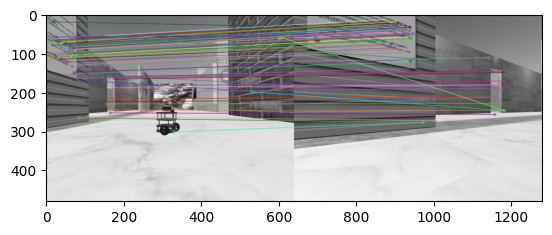

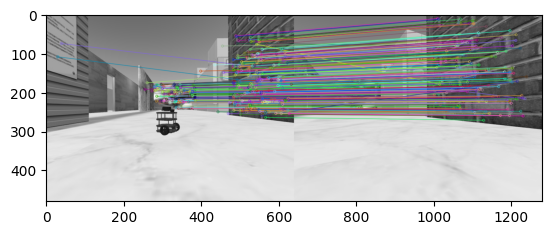

[[-1.83013853]
 [-0.20021103]
 [ 0.        ]]
[[-1.83013853]
 [-0.20021103]
 [ 0.        ]]


In [38]:
img1 = cv.imread("/home/master/debug/robot1.jpg")
img2 = cv.imread("/home/master/debug/robot2.jpg")
img1 = cv.cvtColor(img1,cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2,cv.COLOR_BGR2GRAY)
x_offset = 0.1
y_offset = 0.2
cam_trans = [[x_offset,0,0],[0,y_offset,math.pi/2],[-x_offset,0.0,math.pi],[0,-y_offset,-math.pi/2]]
cam_R = []
cam_t = []
for pose in cam_trans:
    cam_R.append(R.from_euler('z',pose[2],degrees=False).as_matrix())
    cam_t.append(np.array([[pose[0]],[pose[1]],[0]]))

height = img1.shape[0]
widht = img1.shape[1]//4
img1_list = []
img2_list = []
for i in range(4):
    img1_tmp = img1[0:height,i*widht:(i+1)*widht]
    img2_tmp = img2[0:height,i*widht:(i+1)*widht]

    img1_list.append(img1_tmp)
    img2_list.append(img2_tmp)


tmp = img1_list[0]
# plt.imshow(tmp,cmap=plt.get_cmap('gray'))
print(tmp.shape)
# read K
K1_mat=np.array([319.9988245765257, 0.0, 320.5, 0.0, 319.9988245765257, 240.5, 0.0, 0.0, 1.0]).reshape((3,3))
K2_mat=np.array([319.9988245765257, 0.0, 320.5, 0.0, 319.9988245765257, 240.5, 0.0, 0.0, 1.0]).reshape((3,3))

cam_index = [1,2,1,1]
# cam_index = [1,2,2,2]
best_model1 = planar_motion_calcu(img1_list[cam_index[0]],img2_list[cam_index[1]],K1_mat,K2_mat)
best_model2 = planar_motion_calcu(img1_list[cam_index[2]],img2_list[cam_index[3]],K1_mat,K2_mat)

theta1 = -best_model1[0,0]*np.pi/180
phi1 = -best_model1[0,1]*np.pi/180
theta2 = -best_model2[0,0]*np.pi/180
phi2 = -best_model2[0,1]*np.pi/180

R_cam_est  = []
R_cam_est.append(R.from_euler('z', theta1, degrees=False).as_matrix())
R_cam_est.append(R.from_euler('z', theta2, degrees=False).as_matrix())
t_cam_est = []
t_cam_est.append(np.array([[-np.sin(phi1)], [np.cos(phi1)], [0]]))
t_cam_est.append(np.array([[-np.sin(phi2)], [np.cos(phi2)], [0]]))
#create fomulation
t1 = []
t2 = []
rho1 = 0
rho2 = 0
for i in range(0,2):
    R_i = cam_R[2*i]
    t_i = cam_t[2*i]
    R_j = cam_R[2*i+1]
    t_j = cam_t[2*i+1]

    R_cam = R_cam_est[i]
    t_cam = t_cam_est[i]

    t1.append(R_j@t_cam)
    t2.append(t_j - R_cam @ t_i)

e1 = t1[0]
e2 = -t1[1]
l = t2[1] - t2[0]

#三个向量都在平面上
A = np.array([[e1[0][0],e2[0][0]],[e1[1][0], e2[1][0]]])
b = l[0:2]
res = np.linalg.inv(A) @ b
rho1 = res[0][0]
rho2 = res[1][0]

print(rho1*t1[0] + t2[0])
print(rho2*t1[1] + t2[1])

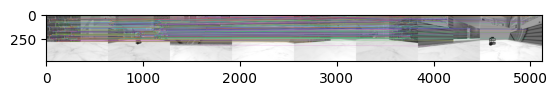

In [36]:
best_model1 = planar_motion_calcu(img1,img2,K1_mat,K2_mat)